# Linear Regression Analysis Flow

## 1. Get the dataset and variables

In [1]:
import pandas as pd
import os
import csv

def read_data(dataset_name, x_col, y_col):
    if dataset_name.endswith('.csv'):
        data = pd.read_csv(dataset_name)
    X = data[x_col]
    Y = data[y_col]
    
    return data, X, Y

In [2]:
dataset_name = 'data/world_happiness.csv'
x_col, y_col = 'GDP per capita', 'Score'
# What to label outliers
i_col = 'Country or region'

In [3]:
data, X, Y = read_data(dataset_name, x_col, y_col)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall rank                  156 non-null    int64  
 1   Country or region             156 non-null    object 
 2   Score                         156 non-null    float64
 3   GDP per capita                156 non-null    float64
 4   Social support                156 non-null    float64
 5   Healthy life expectancy       156 non-null    float64
 6   Freedom to make life choices  156 non-null    float64
 7   Generosity                    156 non-null    float64
 8   Perceptions of corruption     156 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.1+ KB


## 2. Create Linear Regression model

In [5]:
import statsmodels.api as sm

def create_lin_reg_model(X, Y):
    X = sm.add_constant(X) # to include intercept
    lin_reg = sm.OLS(Y, X).fit()
    
    return lin_reg

In [6]:
lin_reg = create_lin_reg_model(X, Y)

### 2.1 Get initial results

Includes slope coefficient, intercept coefficient, and RMSE (root mean squared error - average residual size)

In [25]:
from statsmodels.tools.eval_measures import rmse

def get_lin_reg_results(model):
    
    print('Linear Regression Parameters')
    
    print('Intercept Coefficient: ', model.params[0])
    print('Slope Coefficient: ', model.params[1])
    
    preds = model.predict(sm.add_constant(X))
    print('RMSE: ', rmse(Y, preds))

## 3. Get Correlation Coefficient

Using Pearson's coefficient

In [8]:
from scipy.stats import pearsonr

def get_correlation(X, Y):
    corr, _ = pearsonr(X,Y)
    print('Correlation: ', corr)

In [9]:
get_lin_reg_results(lin_reg)
get_correlation(X, Y)

Intercept Coefficient:  3.3993451782924162
Slope Coefficient:  2.218148001008356
RMSE:  0.6746826955928508
Correlation:  0.7938828678781276


## 4. Identify Outliers

Using studentized residuals. Any points whose studentized residuals is over 3 will be considered an outlier.

In [10]:
def get_outliers(model, data, threshold=3):
    data_copy = data.copy()
    data_copy['Stu_residual'] = model.get_influence().resid_studentized_internal
    return data_copy[abs(data_copy['Stu_residual']) > threshold]

In [11]:
outliers = get_outliers(lin_reg, data)
outliers

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Stu_residual
147,148,Botswana,3.488,1.041,1.145,0.538,0.455,0.025,0.1,-3.281689


In [24]:
def print_outliers(outliers, x_col, y_col, i_col):
    
    print('Outliers')
    
    for i in range(len(outliers)):
        outlier = outliers.iloc[i,:]
        print(outlier[i_col], '(', outlier[x_col], ',', outlier[y_col], ')')

In [13]:
print_outliers(outliers, x_col, y_col, i_col)

Outliers
Botswana ( 1.041 , 3.488 )


## 5. See how linear regression changes if outliers are excluded (is it influential?)

This is not important for the outlier analysis, but let's see if the outliers affect the linear regression dramatically.

In [14]:
data_no_outliers = data.drop(outliers.index)
lin_reg_no_outliers = create_lin_reg_model(data_no_outliers[x_col], data_no_outliers[y_col])
get_lin_reg_results(lin_reg_no_outliers)
get_correlation(data_no_outliers[x_col], data_no_outliers[y_col])

Intercept Coefficient:  3.4025025006593452
Slope Coefficient:  2.230498369014435
RMSE:  0.6748528142161883
Correlation:  0.8058159212573317


Not influential, turns out that it actually drops the quality of the model based on the RSME.

## 6. Plot final visualization

In [152]:
import matplotlib.pyplot as plt
import os

fig_ext = 'png'
dpi=300
def save_plot(name):
    plt.savefig(os.path.join('images', name + '.png'), format=fig_ext, dpi=dpi)


def process_name(name):
    return ('_'.join(name.split())).lower()


def plot_visualization(data, outliers, model, x_col, y_col, i_col):
    
    plt.close()
    fig, ax = plt.subplots()

    # setting labels
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(x_col + ' VS ' + y_col)
    
    # ax.axis('equal')
    
    # plot original data
    ax.scatter(data[x_col], data[y_col], s=4)
    
    # plot outliers
    # for i in range(len(outliers)):
    #     point = outliers.iloc[i,:]
    #     ax.plot(point[x_col], point[y_col], 'rx')
        # ax.text(x=point[x_col], y=point[y_col], s=point[i_col])
    
    # plot line trend
    preds = model.predict(sm.add_constant(X))
    # ax.plot(X, preds, 'g-')
    
    # plot info textbox
    # text_x = ax.get_xlim()[1] + 15
    # text_y = ax.get_ylim()[1] - 4
    # text_content = '\n'.join((
    #     r'$\theta_{0}$: %.2f' % (model.params[0]),
    #     r'$\theta_{1}$: %.2f' % (model.params[1]),
    #     r'Correlation: %.2f' % (get_correlation(data[x_col], data[y_col]))
    # ))
    # ax.text(x=text_x, y=text_y, s=text_content, 
    #         size=10,
    #         bbox=dict(boxstyle='square', fc=(0.9, 0.91, 1))
    # )
    
    # so image doesn't get cut off
    plt.tight_layout() 
    
    save_plot(process_name(x_col) + '_vs_' + process_name(y_col))

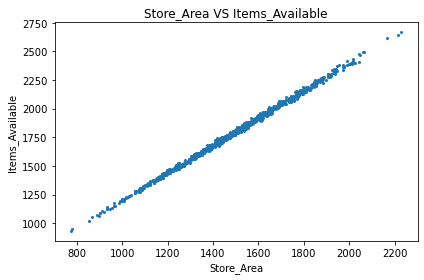

In [153]:
plot_visualization(data, outliers, lin_reg, x_col, y_col, i_col=i_col)

# Try it out

In [154]:
dataset_name = 'data/Stores.csv'
x_col, y_col = 'Store_Area', 'Items_Available'
i_col = 'Store ID '

In [155]:
data, X, Y = read_data(dataset_name, x_col, y_col)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Store ID              896 non-null    int64
 1   Store_Area            896 non-null    int64
 2   Items_Available       896 non-null    int64
 3   Daily_Customer_Count  896 non-null    int64
 4   Store_Sales           896 non-null    int64
dtypes: int64(5)
memory usage: 35.1 KB


In [156]:
lin_reg = create_lin_reg_model(X, Y)

In [157]:
outliers = get_outliers(lin_reg, data)
outliers

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Stu_residual
628,629,2044,2408,380,82020,-3.031132


In [160]:
get_lin_reg_results(lin_reg)
get_correlation(X, Y)
print_outliers(outliers,x_col,y_col,i_col)

Linear Regression Parameters
Intercept Coefficient:  3.9664856973257088
Slope Coefficient:  1.197022848597403
RMSE:  14.11245615411981
Correlation:  0.998890750752833
Outliers
629.0 ( 2044.0 , 2408.0 )


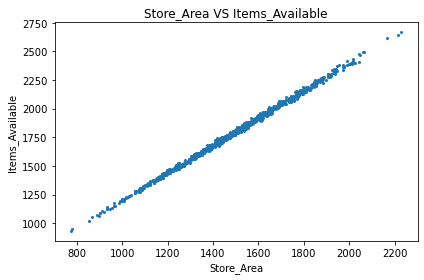

In [159]:
plot_visualization(data, outliers, lin_reg, x_col, y_col, i_col=i_col)